# Lorentz Transmission Electron Microscopy

Lorentz Transmission Electron Microscopy (LTEM) is a technique to image magnetic structures in samples that are thinner than 500 nm. In this tutorial, the Ubermag micromagnetic software is used to create 3-dimensional magnetic structure, from which we simulate two types of image: defocused images and the phase shift that would be recovered from electron holography. 

In LTEM, a parallel beam of electrons with an energy of typically 200 - 300 kV is incident on a thin magnetic sample. As electrons are charged particles, they are deflected by the Lorentz force caused by the magnetic flux density (${\bf B}$) in the specimen. This causes a phase shift in the electron beam compared with a beam travelling through vacuum. An in-focus image corresponds to the state of the electron beam as it exits the specimen (called the exit-plane) and as shown in the LTEM reference frame figure, there is no excess or deficiency of electrons so the image is blank. 

The simplest way to obtain magnetic contrast is to take an out-of-focus image (also called a defocused image) which corresponds to a higher or lower plane as shown in the LTEM reference frame figure. It can be seen that the electron distribution is no longer uniform so that there are intensity variations in the image corresponding to magnetic features.

An alternative method to obtain information on the magnetic structure is off-axis electron holography. It is the most direct way the to measure the phase shift the electrons experience. It is performed using a charged wire called an electron biprism to bring the electrons together and form an interference pattern from which the phase shift can then be calculated.

It is worth noting that as the Lorentz force depends on ${\bf v}\times {\bf B}$ (where ${\bf v}$ is the velocity of the electrons) there is no force along direction of travel of the electron beam, hence Lorentz microscopy is only sensitive to the component of the magnetic flux density normal to the beam.

## LTEM Reference frame

In `mag2exp` the coordinate system is defined by the electron beam propagating along the $z$ direction.
<img src="Figures/LTEM_imaging.png" alt="image" width="500" height="600">

## The micromagnetic simulation

A micromagnetic simulation can be set up using <code>Ubermag</code> to obtain a 3-dimensional magntic structure.

In [1]:
%matplotlib inline
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc
import ubermagutil.units as uu

np.random.seed(1)

region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="T")
    + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6  # A/m


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

Plot the initial magnetisation:

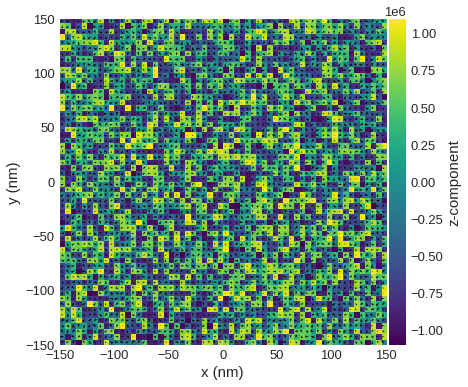

In [2]:
system.m.sel("z").mpl()

Relax the system and plot its magnetisation.

Running OOMMF (ExeOOMMFRunner)[2023/01/17 17:49]... (6.7 s)


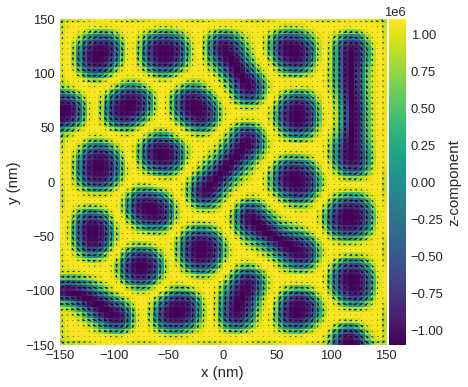

In [3]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

From the magnetisation, we can compute the phase of the electron beam that would be recovered using off-axis holography and as well as defocused images.

## Computing LTEM images

We can use the `mag2exp` package to first calculate the phase shift $\phi_m$ of the electron beam on passing through the specimen. The calculation of the phase is performed in Fourier space:

\begin{equation}
\widetilde{\phi}_m (k_x,k_y)=\frac{i e \mu_0 k_\perp^2}{h} \frac{\left[ \widetilde{\bf M}_I(k_x,k_y)\times {\bf k}_\perp \right] _z}{\left( k_\perp^2 + k_c^2 \right)^2},
\end{equation}
where ${\bf M}_I$ is the integrated magnetisation along the path of the electron beam, $\mu_0$ is the vacuum permeability, and $k$ is the k-vector in Fourier space, as given in Ref \[[Beleggia 2010](https://www.tandfonline.com/doi/abs/10.1080/0141861031000066166)\].
To avoid singularities in Fourier space, a Tikhonov filter is used where $1/k^2$ is replaced by $k^2/(k^2+k_c^2)$ where $k_c$ is the radius of the filter.

The function `mag2exp.ltem.phase` is used to calculate the phase and Fourier transform of the phase. In this function the radius of the Tikhonov filter is defined by `kcx` and `kcy` in units of cell size.

In [4]:
import mag2exp

kcx = kcy = 0.1  # Cell size
phase, ft_phase = mag2exp.ltem.phase(system.m, kcx=kcx, kcy=kcy)

The phase (`phase`) and its Fourier transform (`ft_phase`) are `discretisedfield` objects hence the built in plotting functions can be used to view them.

The phase is plotted via:

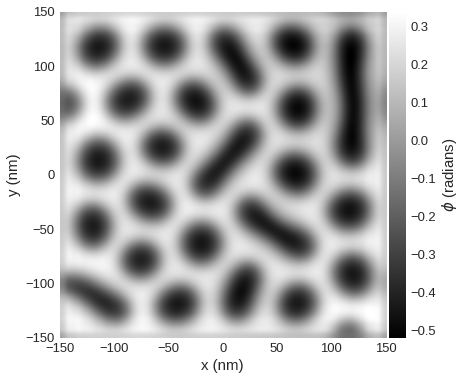

In [5]:
phase.mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label=r"$\phi$ (radians)"
)

The phase recovered by off-axis electron holography may be compared with the phase calculated here.

`mag2exp` has an integrated `quick_plots` functionality which is designed to be easy to use and output figures of the desired quantities directly from the magnetisation texture with all the intermediary calculations performed under the hood. These figures are created with set themes by design, and only take arguments relevant to the quantities being calculated.
The phase of the electrons can be plotted using

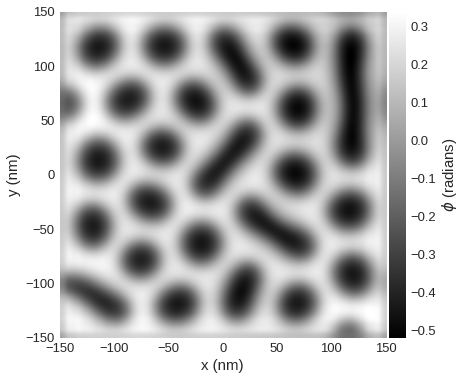

In [6]:
mag2exp.quick_plots.ltem_phase(system.m)

This example shows a plot of $\left\vert\widetilde{\phi}_m\right\vert^2$ with the Tikhonov filter radius indicated by the red circle. This is a useful check that the filter radius is not set too high and does not obliterate significant parts of the Fourier transform.

NOTE: The values of the axis in Fourier space are frequency NOT angular frequency so DO NOT include a factor of $2\pi$. i.e. $|{\bf k}| = \frac{1}{\lambda} \neq \frac{2 \pi}{\lambda}$, where $\bf k$ is the wave vector and $\lambda$ is the wavelength.

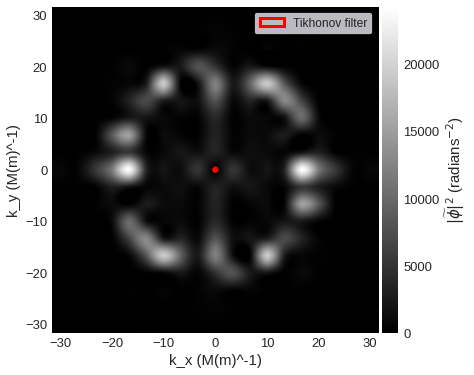

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

centre_region = df.Region(p1=(-30e6, -30e6), p2=(30e6, 30e6))

fig, ax = plt.subplots()
(ft_phase.conjugate * ft_phase)[centre_region].real.mpl.scalar(
    ax=ax,
    cmap="gray",
    interpolation="spline16",
    colorbar_label=r"$\left\vert\widetilde{\phi}\right\vert^2$ (radians$^{-2}$)",
)

multiplier = uu.si_max_multiplier(ft_phase[centre_region].mesh.region.edges)
ax.add_patch(
    Ellipse(
        xy=(0, 0),
        width=ft_phase[centre_region].mesh.cell[0] * kcx * 2 / multiplier,
        height=ft_phase[centre_region].mesh.cell[1] * kcy * 2 / multiplier,
        edgecolor="red",
        facecolor="none",
        linewidth=3,
        label="Tikhonov filter",
    )
)
ax.legend(frameon=True);

The `quick_plots` functions, can simplify this plot into a single line.

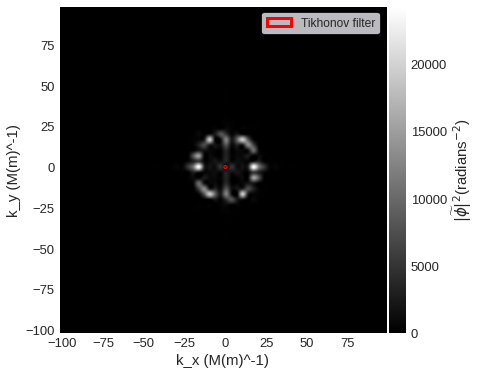

In [8]:
mag2exp.quick_plots.ltem_ft_phase(system.m)

### Defocused Imaging

The wavefunction of the electron beam as it exits the specimen can be calculated using the phase
\begin{equation}
\psi_0 = e^{i\phi_m}.
\end{equation}

Out-of-focus images can be simulated by propagating the wavefunction through free-space by a distance $\Delta f$, known as the defocus, using Contrast Transfer Function $T$ Ref. \[[Bonevich 1994](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.49.6800)\]

\begin{align}
\psi_{\Delta f} &= {\psi}_{0} * T, \\
\widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 \widetilde{T}({\bf k}),\\
\widetilde{\psi}_{\Delta f} &= \widetilde{\psi}_0 e^{2 i \pi k^2 (-\frac{1}{2}\lambda \Delta f + \frac{1}{4} C_s \lambda^3 k^2)}.
\end{align}
$\lambda$ is the relativistic wavelength of the electrons and $C_s$ is the spherical aberration of the electromagnetic lens.

The image at a specific defocus is then given by
\begin{equation}
I_{\Delta f} = \left\vert\psi_{\Delta f}\right\vert^2.
\end{equation}

The intensity of an in-focus image is $I=\left\vert\psi_0\right\vert^2=1$ and so the image appears featureless. Magnetic contrast appears out-of-focus.

The `mag2exp.ltem_defocus_image` function calculates the image at a specific defocus <code>df_length</code>, given the spherical aberration `cs`, and accelerating voltage of the electrons `voltage`.
As an alternative to specifying the accelerating voltage, the wavelength of the electrons `wavelength` can directly be set.

In [9]:
defocus = mag2exp.ltem.defocus_image(phase, voltage=300e3, cs=8000, df_length=-0.4e-3)

The defocused image can then be plotted using the built-in functions.

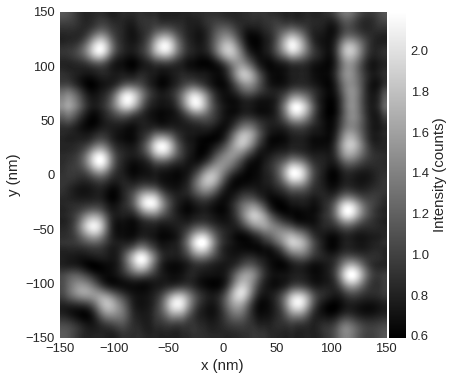

In [10]:
defocus.mpl.scalar(
    cmap="gray", interpolation="spline16", colorbar_label="Intensity (counts)"
)

The `quick_plots` functions can produce this defocus image directly from a magnetisation structure.

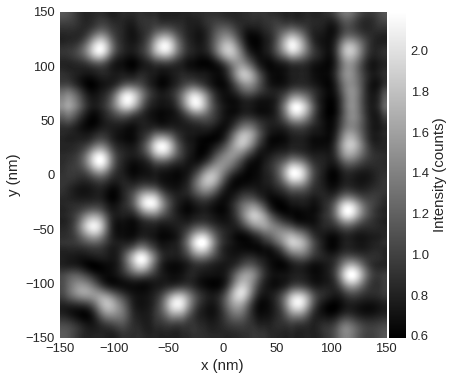

In [11]:
mag2exp.quick_plots.ltem_defocus(system.m, voltage=300e3, cs=8000, df_length=-0.4e-3)

As a rule of thumb, the magnetic feature will only be seen experimentally using this technique if it gives a contrast greater than 1%. The image contrast is defined as
\begin{equation}
{\rm contrast} = \frac{I_{\rm max}-I_{\rm min}}{I_{\rm max} + I_{\rm min}}
\end{equation}
where $I_{\rm max}$ and $I_{\rm max}$ are, respectively, the maximum and minimum intensities of the image.

In [12]:
contrast = (defocus.array.max() - defocus.array.min()) / (
    defocus.array.max() + defocus.array.min()
)
print(f"Contrast: {contrast*100:.1f}%")

Contrast: 57.6%


### Integrated magnetic flux density

From the phase of the electrons other useful quantities can be calculated such as the integrated magnetic flux density ${\bf B}_\perp$. ${\bf B}_\perp$ can be calculated Ref. \[[Tanase 2009](https://doi.org/10.1002/jemt.20671)\] via
\begin{equation}
t{\bf B}_\perp =\frac{\Phi_0}{\pi}\begin{pmatrix} -\partial/\partial y \\ \partial/\partial x \end{pmatrix} \phi_m ,
\end{equation}

where $\Phi_0$ is the magnetic flux quantum and $t$ is the thickness of the sample. 

In [13]:
imf = mag2exp.ltem.integrated_magnetic_flux_density(phase)

The `mpl.lightness` and `mpl.vector` functions can be used to plot this 2-dimensional field. Colour plots use the HSV colour map.

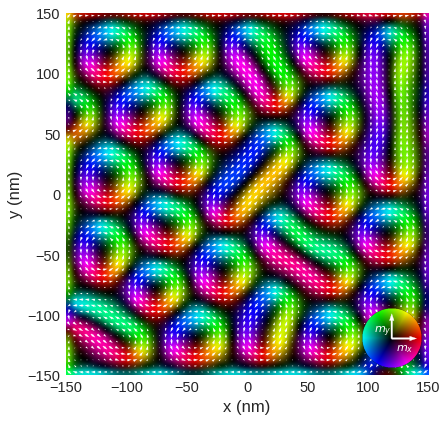

In [14]:
fig, ax = plt.subplots(dpi=80)
imf.mpl.lightness(
    ax=ax,
    clim=[0, 0.5],
    interpolation="spline16",
    colorwheel_args=dict(width=0.75, height=0.75),
    colorwheel_xlabel=r"$m_x$",
    colorwheel_ylabel=r"$m_y$",
)
imf.mpl.vector(ax=ax, vdims=["x", "y"], use_color=False, color="w")

The `quick_plots` functions can produce an images of the integrated magnetic flux density using

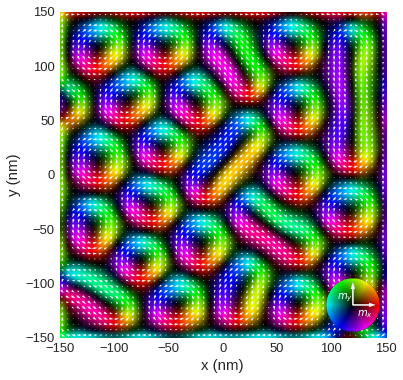

In [15]:
mag2exp.quick_plots.ltem_integrated_mfd(system.m)

`mpl.contour` can be used to plot contours of a scalar field. The contours of the phase can be plotted which resemble magnetic field lines of the integrated magnetic flux density.

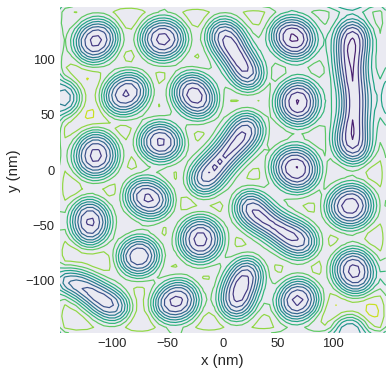

In [16]:
phase.mpl.contour(levels=10, colorbar=False, linewidths=1.2)